In [172]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'


In [61]:
n = 100
d = 50
split_size = 0.2 # proportion of datapoints for test set

f = lambda x: (5*x[0]**3) + (2*x[1]**2) + (10*x[2])

X_train = np.random.normal(size=(int(n*(1-split_size)),d))
X_test = np.random.normal(size=(int(n*split_size),d))
y_train = np.array([f(x) for x in X_train])
y_test = np.array([f(x) for x in X_test])

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 50), (20, 50), (80,), (20,))

In [63]:
X_train[0]

array([-0.39922281,  1.88739423, -2.00344421, -0.32091138,  2.09233142,
       -1.26805035, -0.04155104,  0.33017254, -1.00639809, -0.61746328,
        0.70924958, -0.36018917, -1.58116337,  0.31032964,  0.03035997,
        0.02727838,  1.75470662, -0.04984312, -1.46463037, -0.14630028,
        0.81579021,  0.83376922,  0.14450587, -0.90873373,  0.3913756 ,
        0.38596264, -2.70721234, -0.28563797,  0.27410854, -1.12781396,
        0.08247842, -0.55294822, -0.93493981,  0.39417008, -0.03486334,
        2.18370569, -0.03819321, -0.54106145,  0.64578783, -0.74597041,
        2.21069519, -0.6717807 , -0.49848629,  1.45169632, -0.17775788,
       -0.58645513,  1.62024834, -1.59493215,  0.32950854,  0.31994677])

In [64]:
y_train[0]

-13.228066592320555

In [65]:
def mnorm(x, z, M, squared=True): # (n, d), (m,d), (d,d) --> (n, m)
    # implements |x-z|_M^2 between pairs from x and z
    x_norm = ((x @ M)*x).sum(axis=1, keepdims=True)
    if x is z:
        z_norm = x_norm
    else:
        z_norm = ((z @ M)*z).sum(axis=1, keepdims=True)
        
    z_norm = z_norm.reshape(1, -1)
    
    distances = (x @ (M @ z.T)*-2) + x_norm + z_norm
    if not squared:
        distances = np.sqrt(np.clip(distances, 0, np.inf))
    return distances

In [66]:
M = np.eye(d)

mnorm(X_train, X_train, M, squared=False)

array([[0.00000000e+00, 9.32539938e+00, 1.00598902e+01, ...,
        1.17195850e+01, 1.08386694e+01, 1.08665703e+01],
       [9.32539938e+00, 2.06476546e-07, 1.11660653e+01, ...,
        1.03910205e+01, 1.07957356e+01, 1.15315257e+01],
       [1.00598902e+01, 1.11660653e+01, 0.00000000e+00, ...,
        1.01210916e+01, 1.04770051e+01, 1.05970446e+01],
       ...,
       [1.17195850e+01, 1.03910205e+01, 1.01210916e+01, ...,
        1.19209290e-07, 1.07200136e+01, 1.05144260e+01],
       [1.08386694e+01, 1.07957356e+01, 1.04770051e+01, ...,
        1.07200136e+01, 2.38418579e-07, 1.06830102e+01],
       [1.08665703e+01, 1.15315257e+01, 1.05970446e+01, ...,
        1.05144260e+01, 1.06830102e+01, 0.00000000e+00]])

In [67]:
import os
import logging

logger = logging.getLogger(__name__)

os.chdir("../")

import src.utils as utils

In [68]:
def K_M(x, z, M, L):
    pairwise_distances = mnorm(x, z, M, squared=False)
    pairwise_distances = np.clip(pairwise_distances, 0, np.inf)
    return np.exp(pairwise_distances * -(1./L))

grad_laplace_mat = lambda a, x, z, M, L: utils.grad_laplace_mat(x, a, L, M)

In [69]:
T = 10
L = 1.
M = np.eye(d)

_lambda = 1e-3


def train_rfm(X_train, y_train, L=1., T=10):
    n, d = X_train.shape
    M = np.eye(d)
    for t in range(T):
        K_train = K_M(X_train, X_train, M, L=L)
        alpha = y_train @ np.linalg.pinv(K_train + _lambda*np.eye(n))
        M = grad_laplace_mat(alpha, X_train, X_train, M, L=L)
        
    return alpha, M

alpha, M = train_rfm(X_train, y_train, L, T)

/Users/arunavgupta/Documents/WI23/ml-theory-capstone/src/utils.py:101: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


In [70]:
alpha.shape, M.shape

((80,), (50, 50))

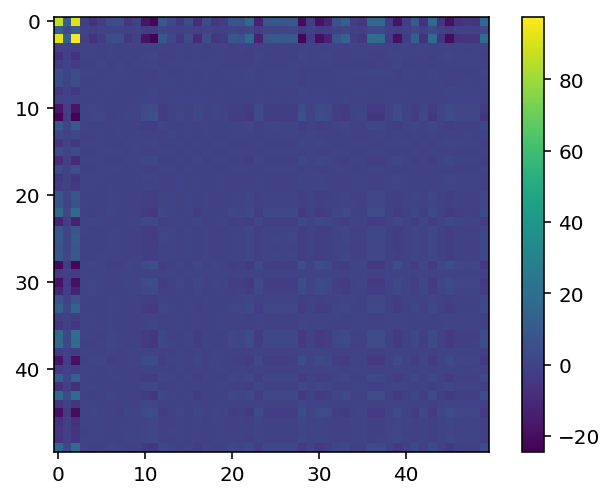

In [71]:
plt.imshow(M)
plt.colorbar()

In [72]:
y_pred_train = alpha @ K_M(X_train, X_train, M, L)
((y_train - y_pred_train)**2).mean()

10.300010396391405

In [73]:
K_M(X_train, X_test, M, L).shape

(80, 20)

In [74]:
y_pred_test = alpha @ K_M(X_train, X_test, M, L)
((y_test - y_pred_test)**2).mean()

163.1312406125435

## Scaling Test

In [109]:
M.shape

(50, 50)

In [153]:
def apply_norm_control(M, top_k=0.1, strategy="eig", debug=False):
    """Use top-k eigenvalues to control M (:= (1/n)* J.T @ J)'s norm"""
    # take the top 10% of the significant values
    k = int(M.shape[0] * top_k)
    if strategy == "eig":
        w, v = np.linalg.eigh(M)
        w, v = w[k:], v[:,k:]

        # reconstruct M
        N = np.dot(v, np.dot(np.diag(w), v.T))
    elif strategy == "svd":
        u, s, v = np.linalg.svd(M, full_matrices=False)
        N = np.dot(u[:, :k], np.dot(np.diag(s[:k]), v[:k, :]))
    else:
        raise ValueError("Strategy must be 'eig' or 'svd'.")
    
    if debug:
        print(f"[Norm Control] starting norm: {np.linalg.norm(M)}")
        print(f"[Norm Control] ending norm: {np.linalg.norm(N)} \t distance: {np.linalg.norm(M - N)}")
    
    return N   
    

In [166]:
from tqdm import trange


def run_one_sim(stdev_control=True, norm_control=True):
    train_MSE = []
    test_MSE = []
    M_norm = []
    stdevs = []
    
    n, _d = (100, 200) # starting size
    
    # Regenerate training data
    X_train = np.random.normal(size=(int(n*(1-split_size)),_d))
    X_test = np.random.normal(size=(int(n*split_size),_d))
    
    print(f"Starting stdev: {np.std(X_train)}")

    for d in trange(10, 200):
        # slice and renormalize data
        train_X = X_train[:, :d] * (1/np.sqrt(d))
        test_X = X_test[:, :d] * (1/np.sqrt(d))
        
        if stdev_control:
            train_X *= 1/np.sqrt(d)
            test_X *= 1/np.sqrt(d)
        
        stdevs.append(np.std(train_X))

        # recompute y_train and y_test
        train_y = np.array([f(x) for x in train_X])
        test_y = np.array([f(x) for x in test_X])

        alpha, M = train_rfm(train_X, train_y, L, T)
        
        if norm_control:
            M = apply_norm_control(M, strategy="svd")

        M_norm.append(np.linalg.norm(M))

        # train mse
        y_pred_train = alpha @ K_M(train_X, train_X, M, L)
        train_MSE.append(((train_y - y_pred_train)**2).mean())

        # test mse
        y_pred_test = alpha @ K_M(train_X, test_X, M, L)
        test_MSE.append(((test_y - y_pred_test)**2).mean())
    
    return np.array(train_MSE), np.array(test_MSE), np.array(M_norm), np.array(stdevs)

In [185]:
train_MSE, test_MSE, M_norm, stdevs = run_one_sim()

Starting stdev: 0.9999577252171615


  0%|                                                                                     | 0/190 [00:00<?, ?it/s]/Users/arunavgupta/Documents/WI23/ml-theory-capstone/src/utils.py:101: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist
100%|███████████████████████████████████████████████████████████████████████████| 190/190 [00:11<00:00, 16.79it/s]


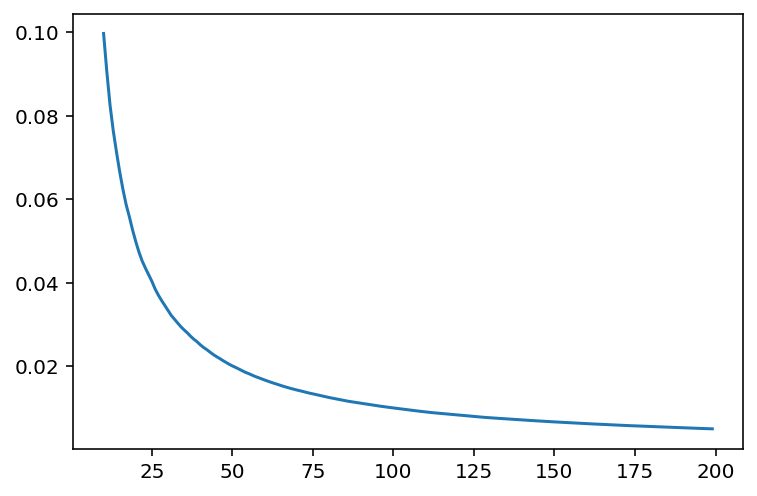

In [186]:
plt.plot(d_range, stdevs)

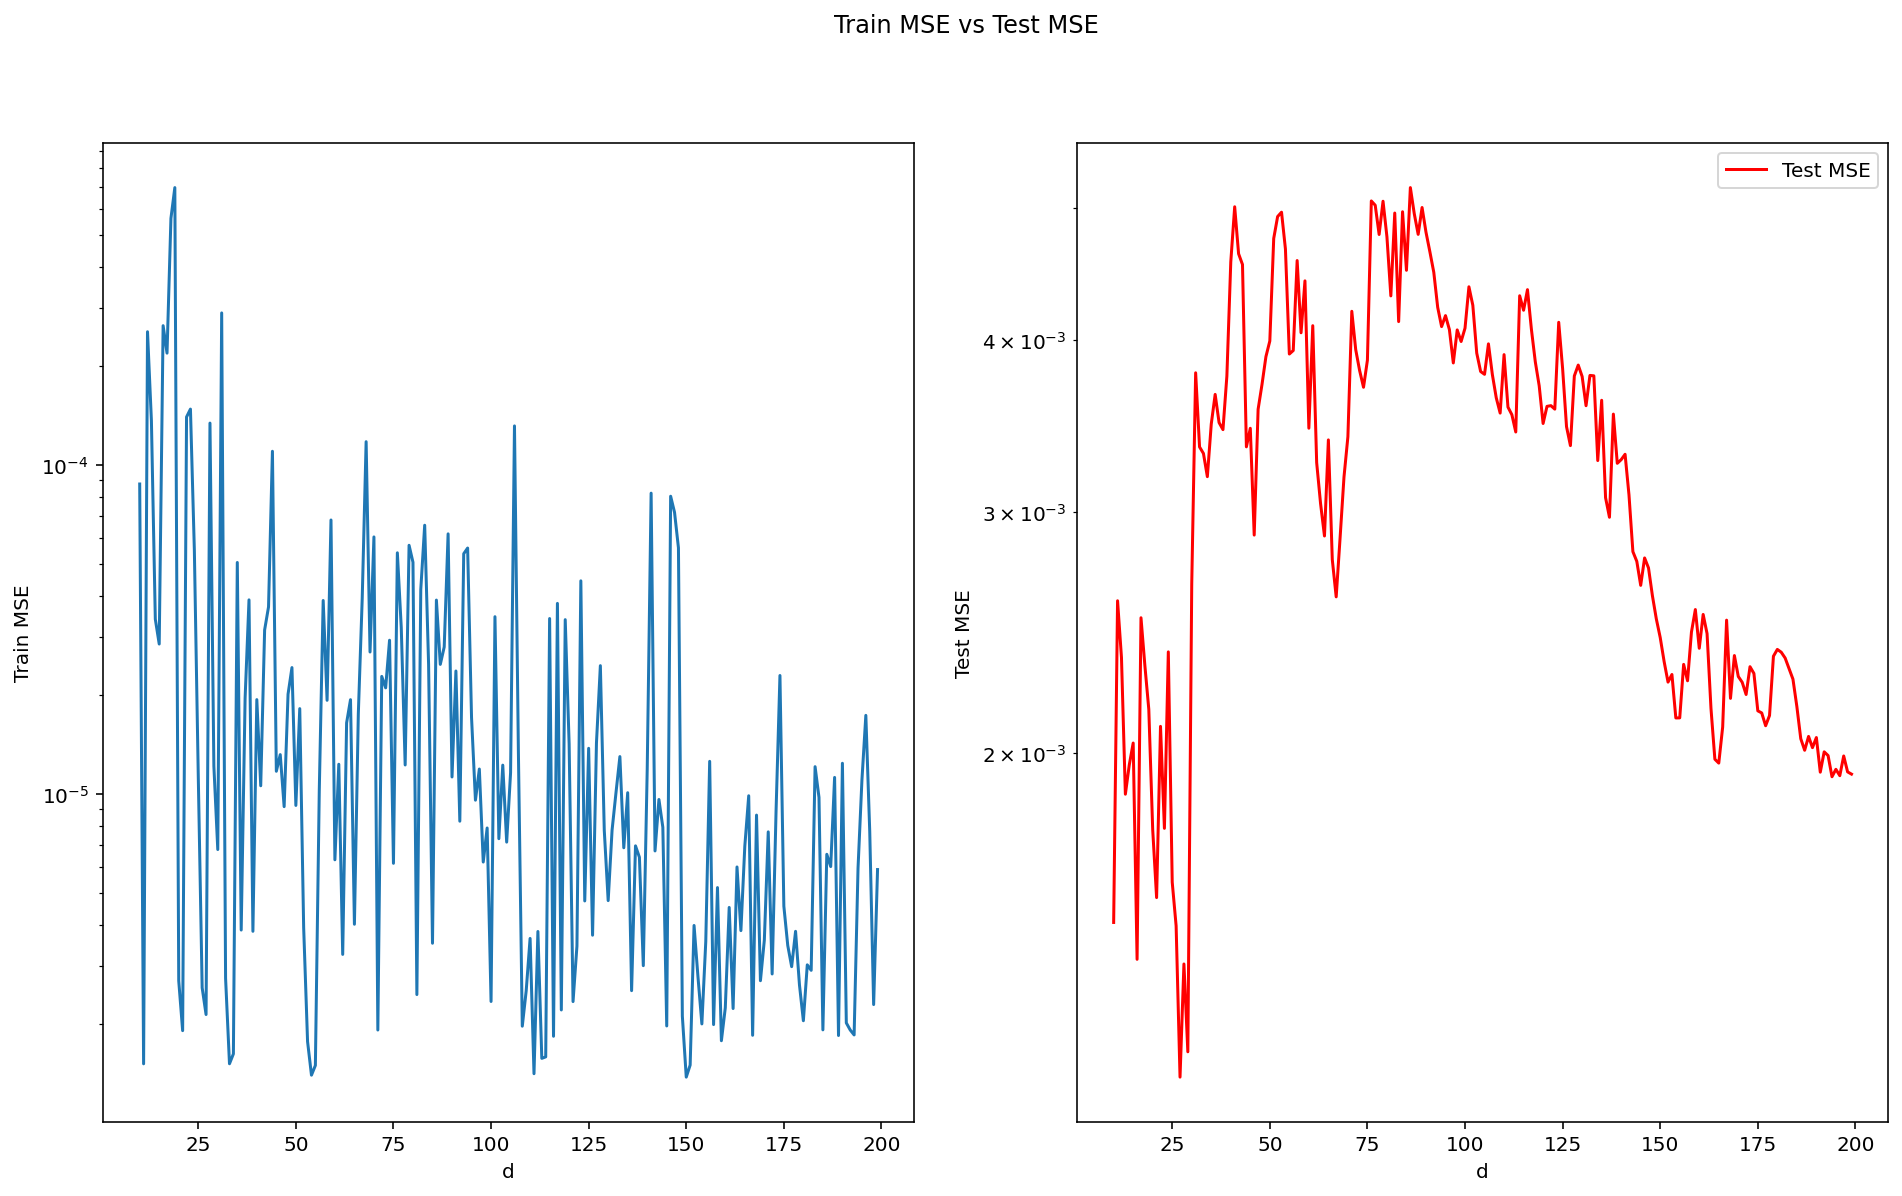

In [187]:
d_range = list(range(10, 200))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
fig.suptitle("Train MSE vs Test MSE")

ax1.set_xlabel("d")
ax1.semilogy(d_range, train_MSE, label="Train MSE")
ax1.set_ylabel("Train MSE")

ax2.set_xlabel("d")
ax2.semilogy(d_range, test_MSE, color='r', label="Test MSE")
# ax2.set_xscale("log")
ax2.set_ylabel("Test MSE")

plt.legend()

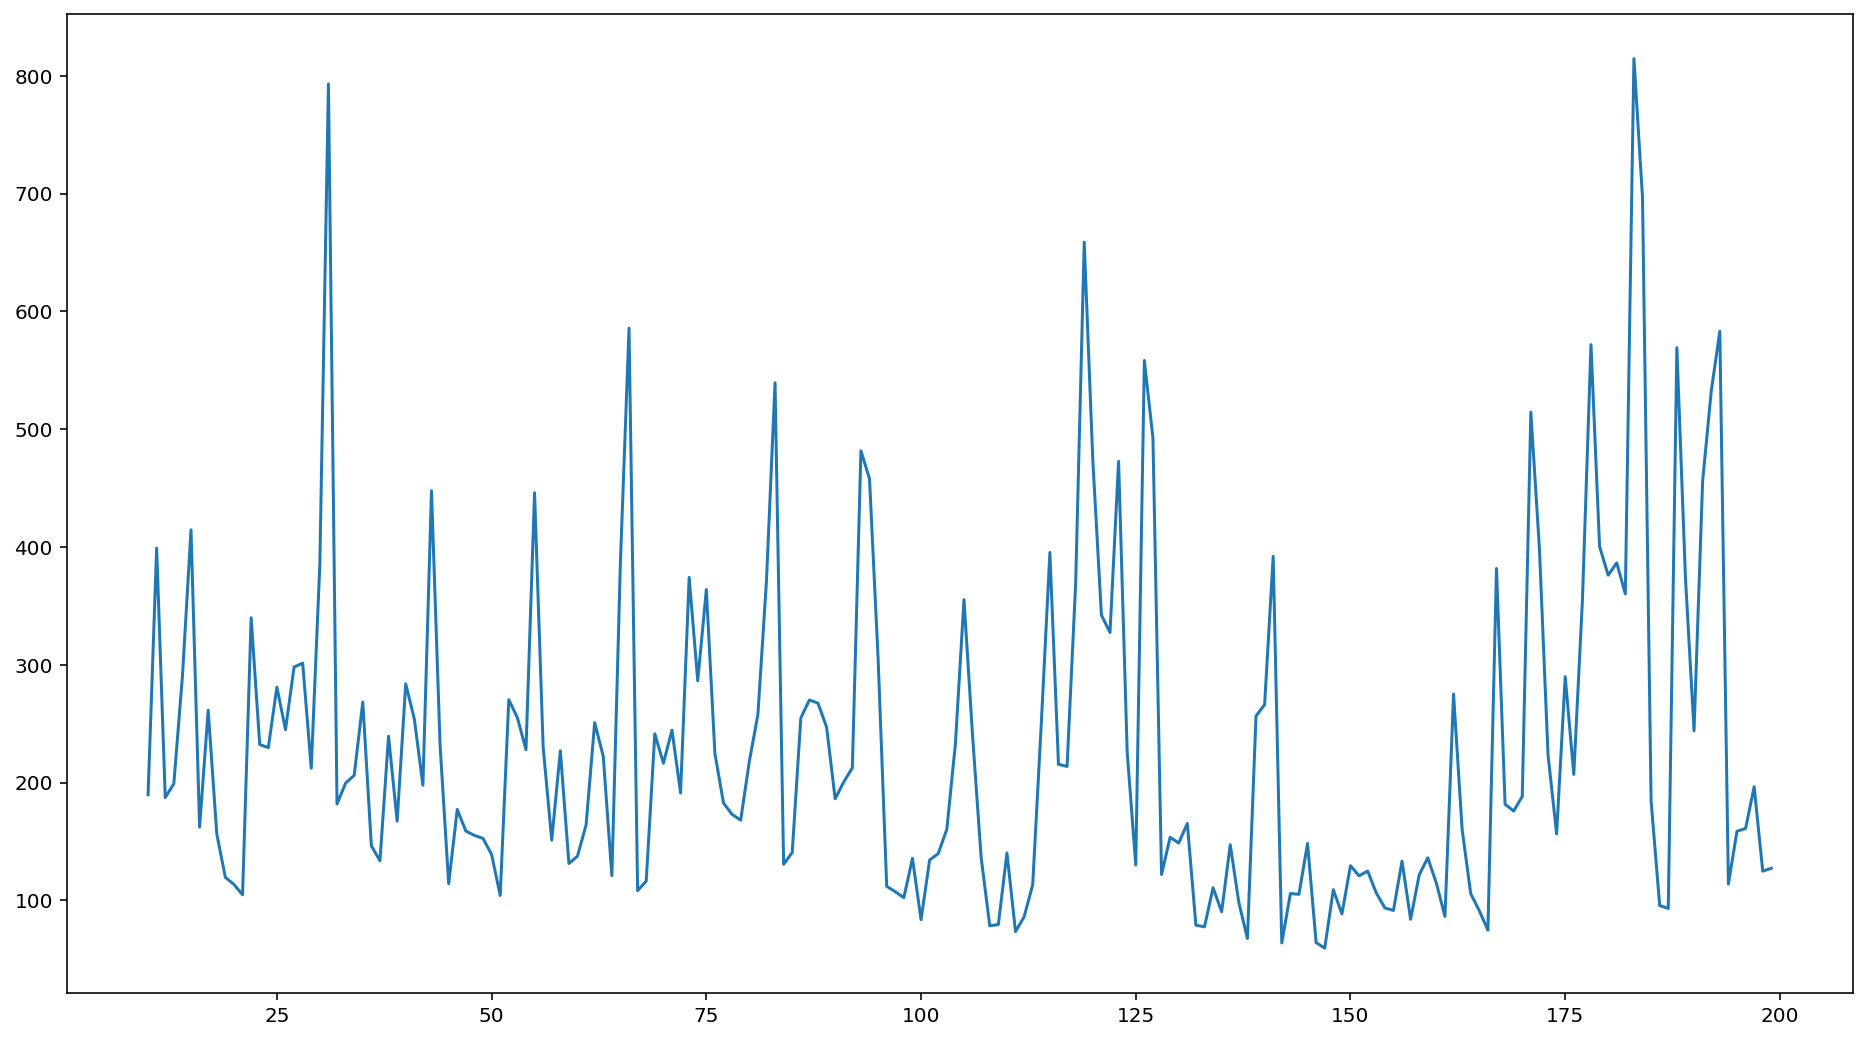

In [188]:
plt.figure(figsize=(16,9))
plt.plot(d_range, M_norm)
# plt.yscale("log")

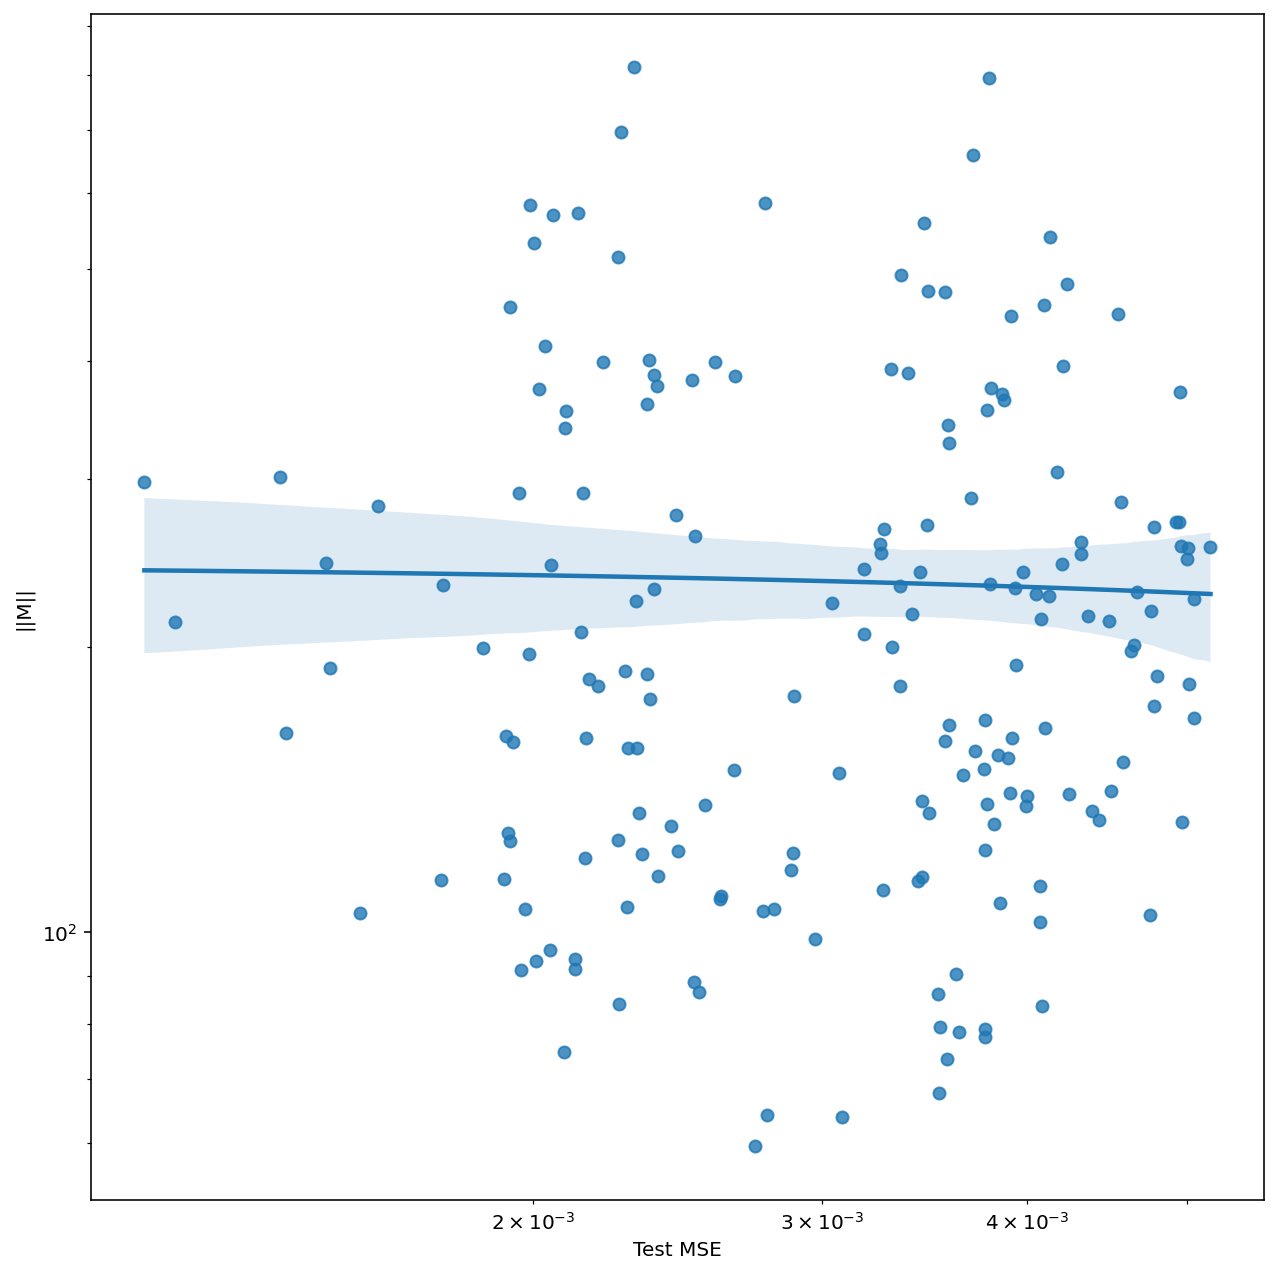

In [190]:
plt.figure(figsize=(9, 9))
sns.regplot(x=test_MSE, y=M_norm)

plt.xlabel("Test MSE")
plt.ylabel("||M||")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()

In [20]:
M

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
np.linalg.eig(M) # use scipy eigs

AttributeError: module 'numpy.linalg' has no attribute 'eigs'

In [22]:
# check error bounds on subsetting for gradient approximation
# eigenvalues/vectors of M
# try M^2, M^3, ...
# text datasets

In [1]:
# overfitting
# X_d = X[:, :d] * (1/\sqrt(d))
# also recompute y after this
# run 100 runs, average it


# thresholding
# rsvd(J, q) -> sklearn as randomized svd

In [ ]:
# text
# plain kernel vs trigrams/bigrams
# trigram markov chain
# good-turing smoothing
# evaluate on perplexity (find a package)
# error rate
# bleu scores